In [20]:
from PIL import Image
from glob import glob
from matplotlib import cm, image, patches, pyplot as plt
import io

import cv2
import numpy as np


In [2]:
# cut raw img data into n*n array
# data_path = "/home/z/MVPC10/DATA/mvpc10/**/*.jpg"
data_path = "/home/z/MVPC10/DATA/*.jpeg"

In [3]:
files = []
for file in glob(data_path):
    files.append(file)
print(len(files))

1


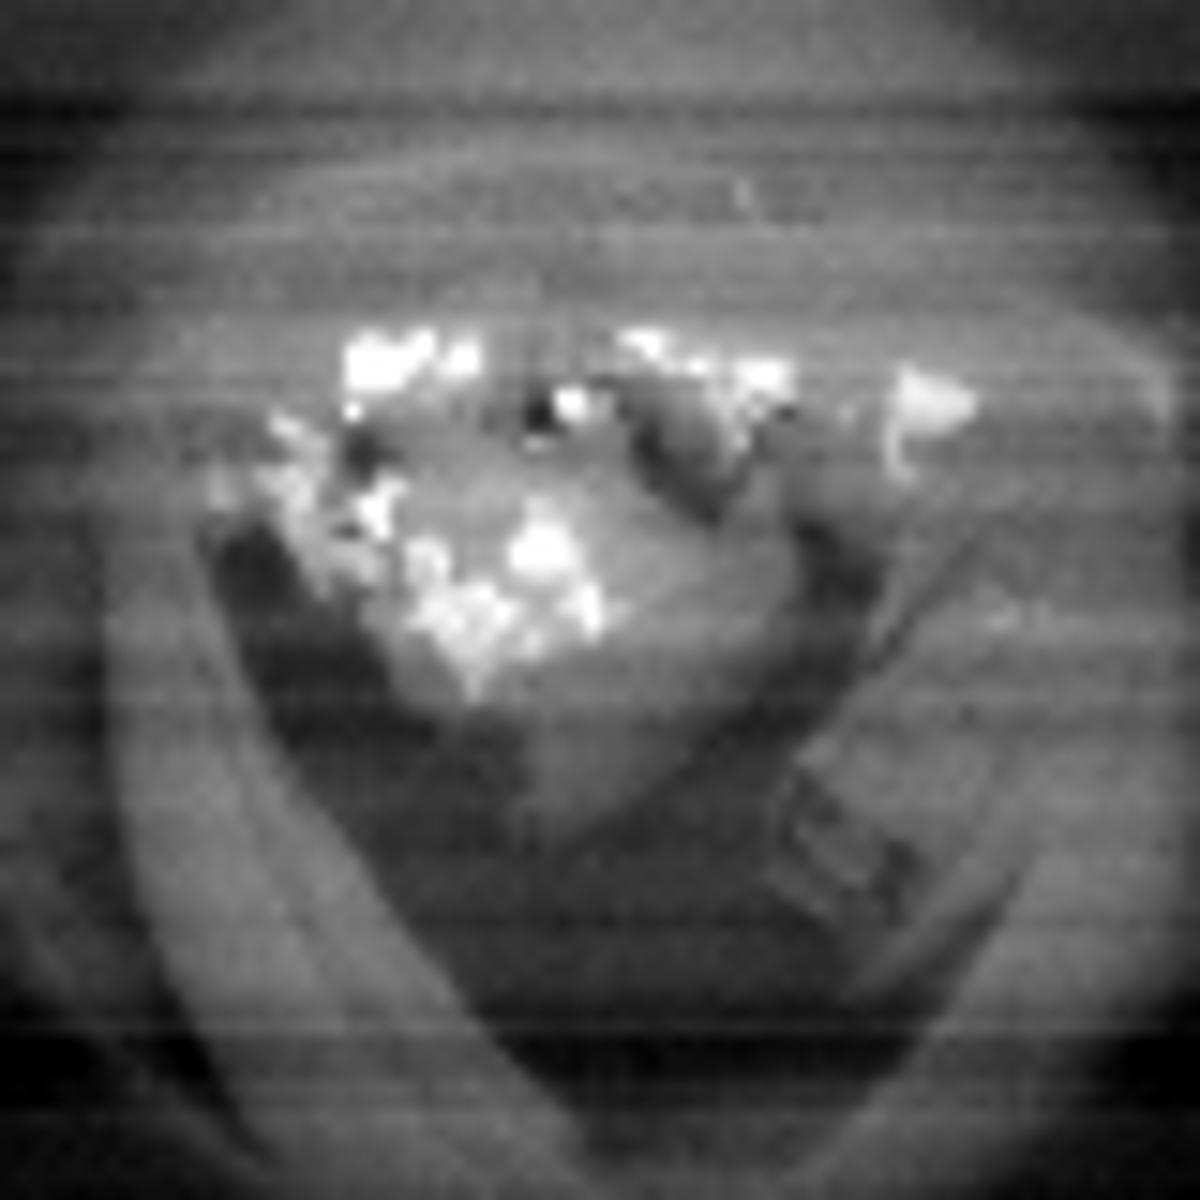

In [4]:
raw_img = Image.open(files[0]).convert('L')

img_resize = raw_img.resize([1200,1200])

display(img_resize)

In [244]:
img_arr = np.array(raw_img)
w, h = img_arr.shape
print(w, h)
# for i in img_arr:
#     print(i)
print(img_arr[0])
print(img_arr[79])


80 80
[ 44  44  48  46  49  45  50  50  50  50  51  56  52  52  61  58  68  71
  69  81  89  96  92  98  98  97 107  99 102 108 107 114 116 113 111 119
 114 113 121 118 120 117 116 111 120 114 112 116 117 111 117 112 113 112
 115 106 102 104 100  96  91  87  75  68  64  57  59  49  54  52  52  49
  49  46  49  44  45  45  41  40]
[ 9  9 13  8  7  4  9  9  8 14 14 14 11 19 17 25 32 39 45 53 56 62 67 63
 68 68 71 73 71 77 70 76 86 71 71 73 77 74 80 83 76 70 67 58 69 69 69 75
 70 74 80 81 73 72 76 64 64 67 62 57 55 49 41 40 32 27 14 11 12  8 13 10
 10  9  9  4  9  5  2  1]


In [249]:
def normalize(img, min, max, w, h):
    """
    :return: normalize img from min to max and reshape to w, h
    """
    norm = np.array([])
    for i in img:
        norm = np.append(norm, (i/max), axis=0).astype(np.float16)
    norm = np.reshape(norm, (w, h))
    return norm

In [238]:
def add_channel(img):
    # img = np.expand_dims(img_arr, axis=-1)
    # img = img_arr.reshape(img_arr.shape[0], img_arr.shape[1], 1)
    reshaped_img = img.reshape(img.shape[0], img.shape[1], 1)
    return reshaped_img

In [239]:
reshaped_img = add_channel(img_arr)
w, h, c = reshaped_img.shape
print(w, h, c)
print(reshaped_img[:4,:4,:])

80 80 1
[[[44]
  [44]
  [48]
  [46]]

 [[46]
  [40]
  [40]
  [41]]

 [[41]
  [42]
  [44]
  [46]]

 [[41]
  [43]
  [42]
  [45]]]


In [265]:
def loop_tiler(img, t_w, t_h, dtype):
    w1, h1 = w//t_w, h//t_h
    tile = np.zeros((h1, w1, t_h, t_w)).astype(dtype)
    y = x = 0
    for i in range(0, h, t_h):
        for j in range(0, w, t_w):
            tile[y][x] = img[i:i+t_h, j:j+t_w]
            x += 1
        y += 1
        x = 0
    return tile, w1, h1

In [154]:
def reshape_tiler(img, t_w, t_h):
    w1, h1 = w//t_w, h//t_h
    tile = img.reshape(h1, t_h, w1, t_w)
    tile = tile.swapaxes(1, 2)
    return tile, w1, h1

80
2 2 2 2 5
2 4 6 8 16   20 40

In [155]:
def tiler(img, t_w, t_h):
    tile, rows, columns = loop_tiler(img, t_w, t_h)
    tli = []
    n, m = 0, 0
    for i in range(rows*columns):
        t = tile[n,m]
        m += 1
        if m == rows:
            n += 1
            m = 0
        if n == columns: n = 0
        tli.append(t)
    return tli

In [262]:
def tile_plotter(img, t_w, t_h, min, max, dtype):
    tile, rows, columns = loop_tiler(img, t_w, t_h, dtype)
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=[20,20])
    n, m = 0, 0
    grid = rows*columns
    if grid==1: plt.imshow(tile[n,m], cmap=cm.magma, vmin=min, vmax=max,)
    else:
        for i in range(grid):
            ax[n,m].axis('off')
            ax[n,m].imshow(tile[n,m], cmap=cm.magma, vmin=min, vmax=max,)
            m += 1
            if m == rows:
                n += 1
                m = 0
            if n == columns: n = 0

    return plt

In [263]:
normed_img = normalize(img_arr, 0, 255, w, h)
print(normed_img.shape)
# for i in normed_img:
#     print(i)
print(normed_img[0])
print(normed_img[79])


(80, 80)
[0.1726 0.1726 0.1882 0.1804 0.1921 0.1765 0.196  0.196  0.196  0.196
 0.2    0.2196 0.204  0.204  0.2393 0.2274 0.2666 0.2783 0.2705 0.3176
 0.349  0.3765 0.3608 0.3843 0.3843 0.3804 0.4197 0.3882 0.4    0.4236
 0.4197 0.447  0.4548 0.443  0.4353 0.4666 0.447  0.443  0.4746 0.4626
 0.4707 0.4587 0.4548 0.4353 0.4707 0.447  0.4392 0.4548 0.4587 0.4353
 0.4587 0.4392 0.443  0.4392 0.451  0.4158 0.4    0.408  0.392  0.3765
 0.357  0.341  0.2942 0.2666 0.251  0.2235 0.2313 0.1921 0.2118 0.204
 0.204  0.1921 0.1921 0.1804 0.1921 0.1726 0.1765 0.1765 0.1608 0.1569]
[0.0353  0.0353  0.051   0.03137 0.02745 0.01569 0.0353  0.0353  0.03137
 0.0549  0.0549  0.0549  0.04315 0.0745  0.06665 0.098   0.1255  0.153
 0.1765  0.2079  0.2196  0.2432  0.2627  0.2471  0.2666  0.2666  0.2783
 0.2864  0.2783  0.302   0.2744  0.298   0.3372  0.2783  0.2783  0.2864
 0.302   0.2903  0.3137  0.3254  0.298   0.2744  0.2627  0.2274  0.2705
 0.2705  0.2705  0.2942  0.2744  0.2903  0.3137  0.3176  0.2864 

In [278]:
tile, rows, columns = loop_tiler(normed_img, 8, 8, np.float16)
print(tile.shape)
# for i, j in enumerate(tile):
#     print(i, j)
tile[9,9]

(10, 10, 8, 8)


array([[0.1255 , 0.0784 , 0.03137, 0.01569, 0.0196 , 0.00392, 0.     ,
        0.     ],
       [0.08234, 0.04315, 0.0353 , 0.03137, 0.00392, 0.     , 0.00784,
        0.     ],
       [0.1137 , 0.098  , 0.0863 , 0.08234, 0.06274, 0.04315, 0.0392 ,
        0.05884],
       [0.0902 , 0.0863 , 0.05884, 0.0549 , 0.0549 , 0.0549 , 0.0353 ,
        0.051  ],
       [0.06665, 0.06274, 0.06274, 0.06274, 0.051  , 0.0196 , 0.0353 ,
        0.0353 ],
       [0.06665, 0.06274, 0.051  , 0.03137, 0.03137, 0.0392 , 0.01569,
        0.03137],
       [0.04706, 0.0784 , 0.0392 , 0.04315, 0.04315, 0.03137, 0.0392 ,
        0.0353 ],
       [0.0392 , 0.0353 , 0.0353 , 0.01569, 0.0353 , 0.0196 , 0.00784,
        0.00392]], dtype=float16)

In [267]:
tile, rows, columns = loop_tiler(img_arr, 8, 8, int)
print(tile.shape)
# for i, j in enumerate(tile):
#     print(i, j)
tile[0,0]


(10, 10, 8, 8)


array([[44, 44, 48, 46, 49, 45, 50, 50],
       [46, 40, 40, 41, 40, 39, 43, 45],
       [41, 42, 44, 46, 45, 47, 44, 43],
       [41, 43, 42, 45, 41, 44, 43, 41],
       [36, 43, 47, 41, 48, 40, 43, 45],
       [38, 35, 45, 43, 50, 44, 49, 42],
       [23, 21, 26, 28, 29, 29, 32, 35],
       [12, 10, 16, 16, 10, 20, 16, 22]])

In [268]:
low_cut = 91
high_cut = 300
min = 0
max = 255

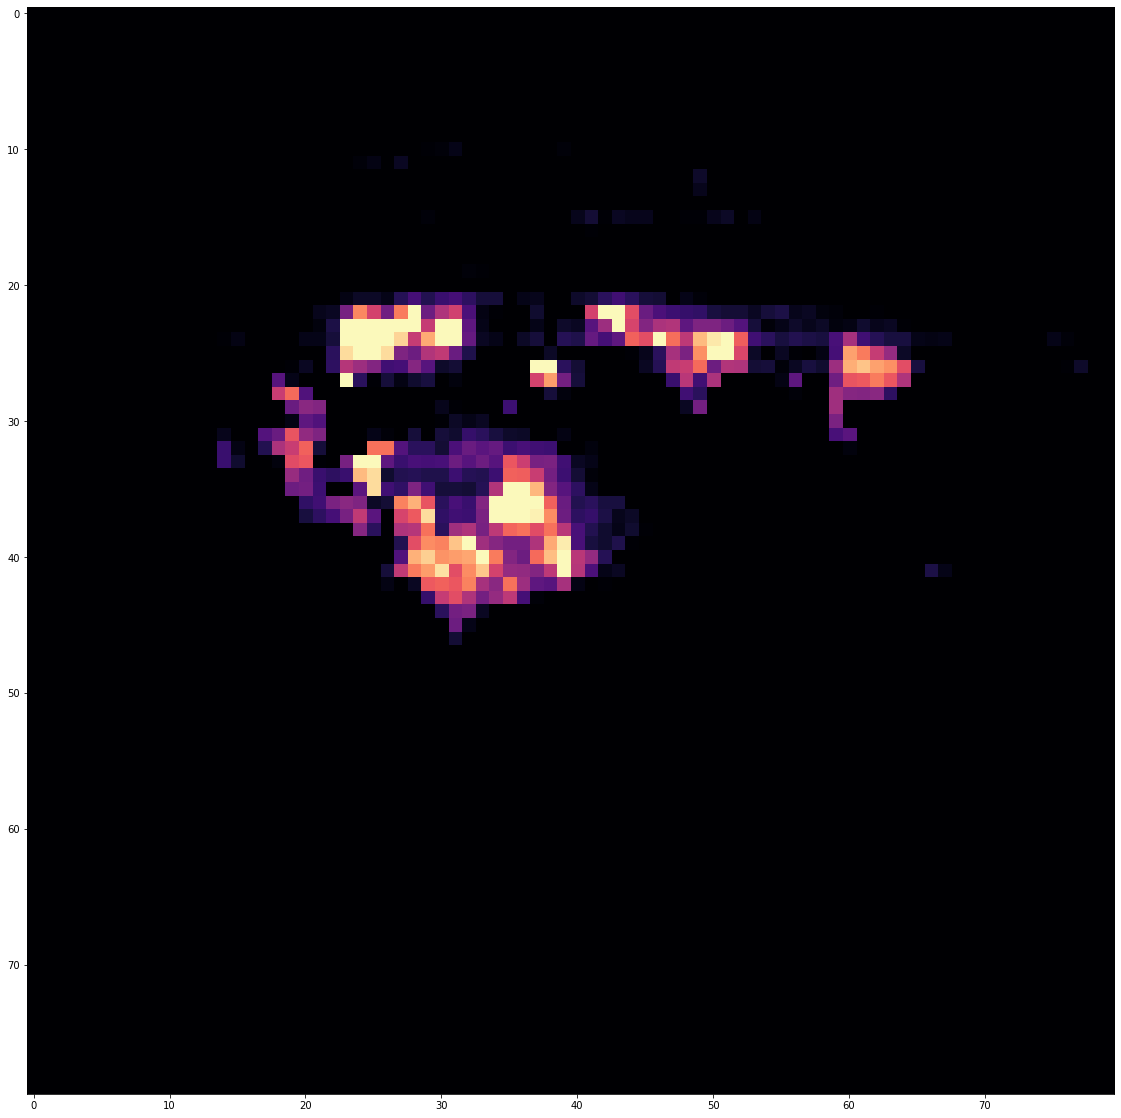

In [274]:
plot = tile_plotter(img_arr, 80, 80, 143, 255, int)
plot.show()

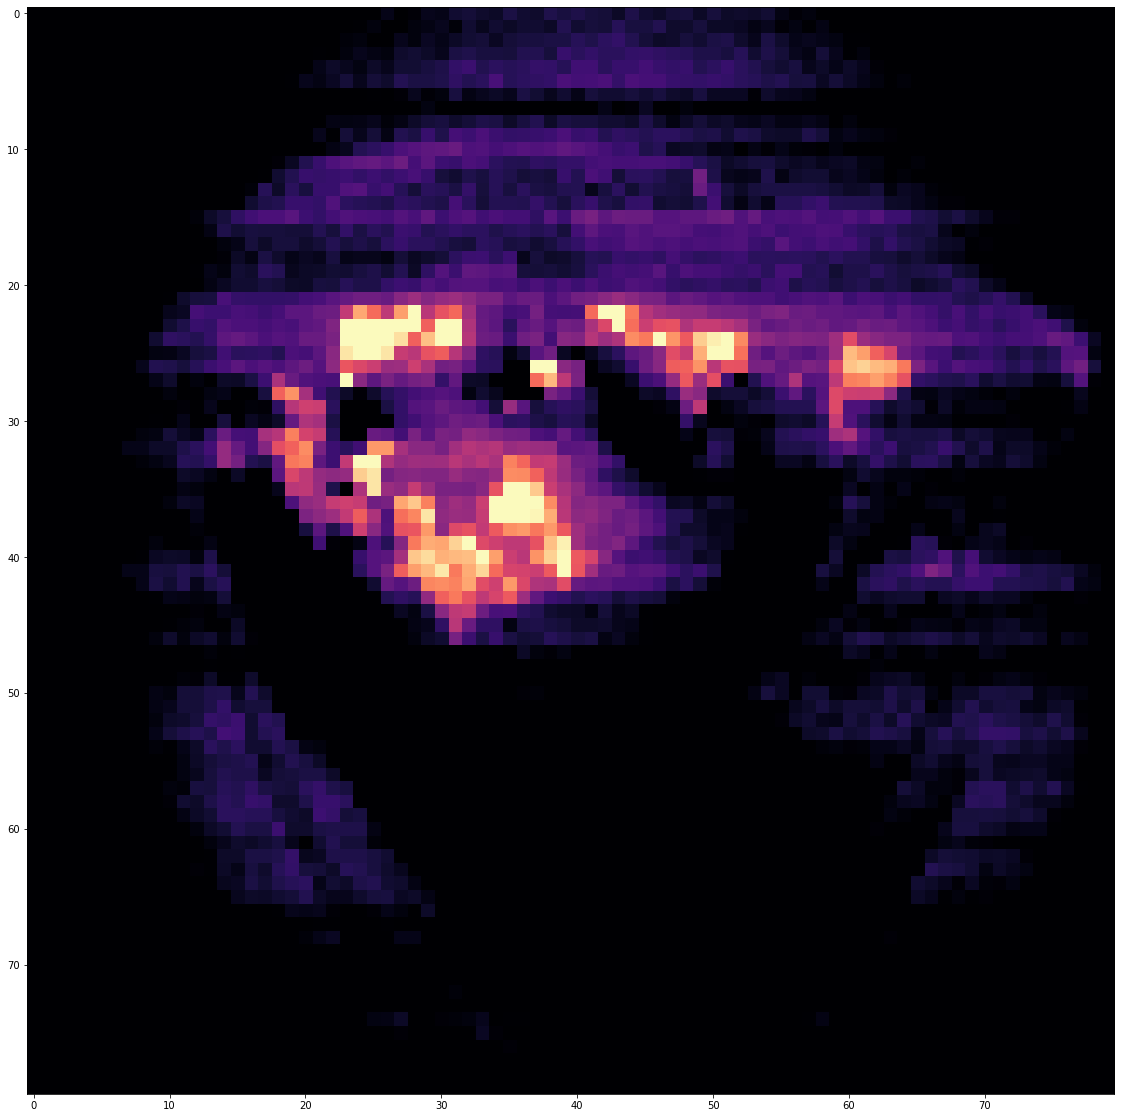

In [160]:
plot = tile_plotter(img_arr, 80, 80, 100, 255, int)
plot.show()

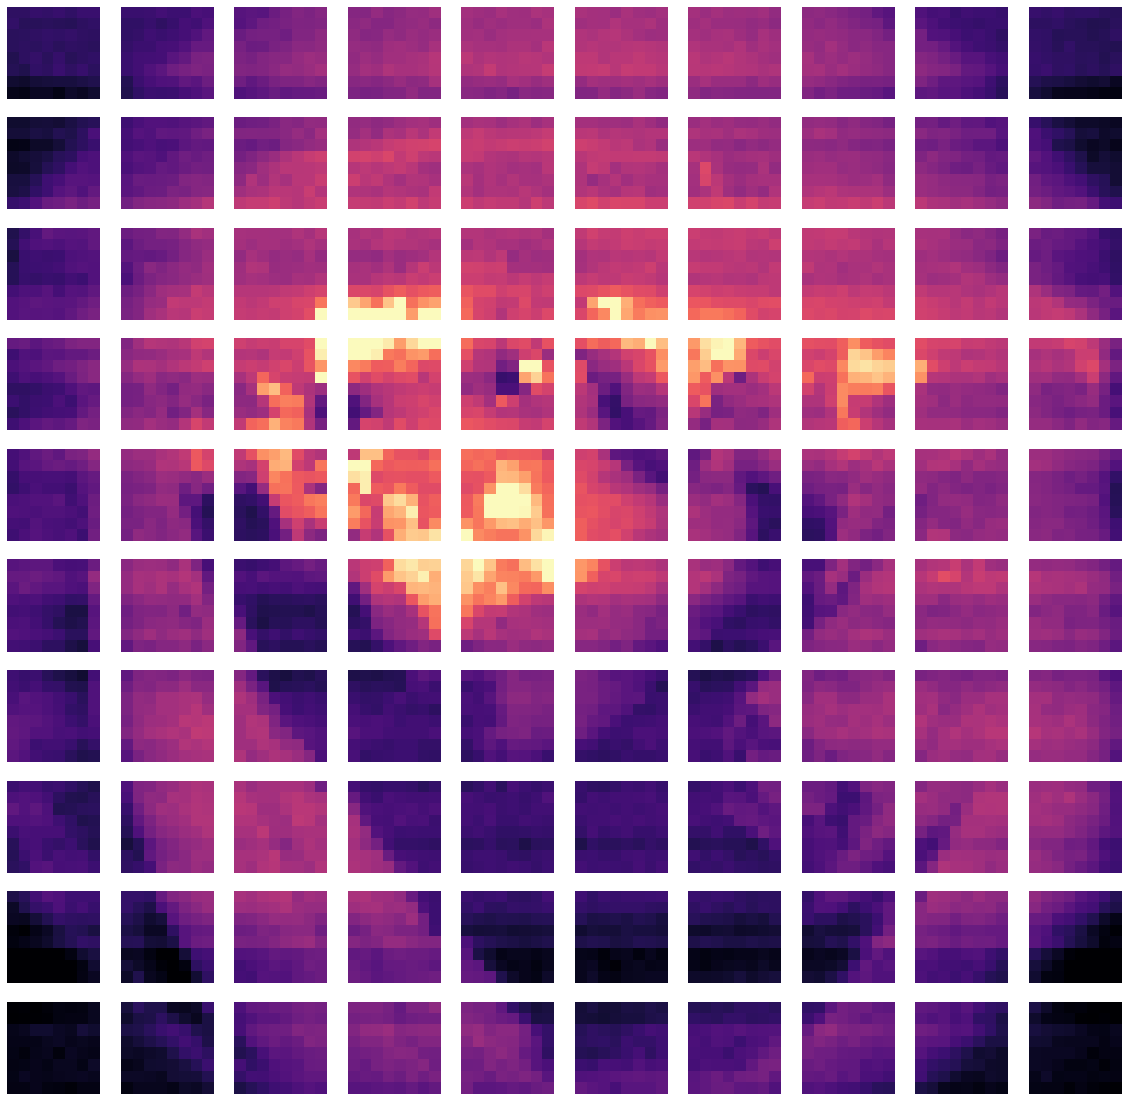

In [237]:
plot = tile_plotter(img_arr, 8, 8, 0, 255, int)
plot.show()

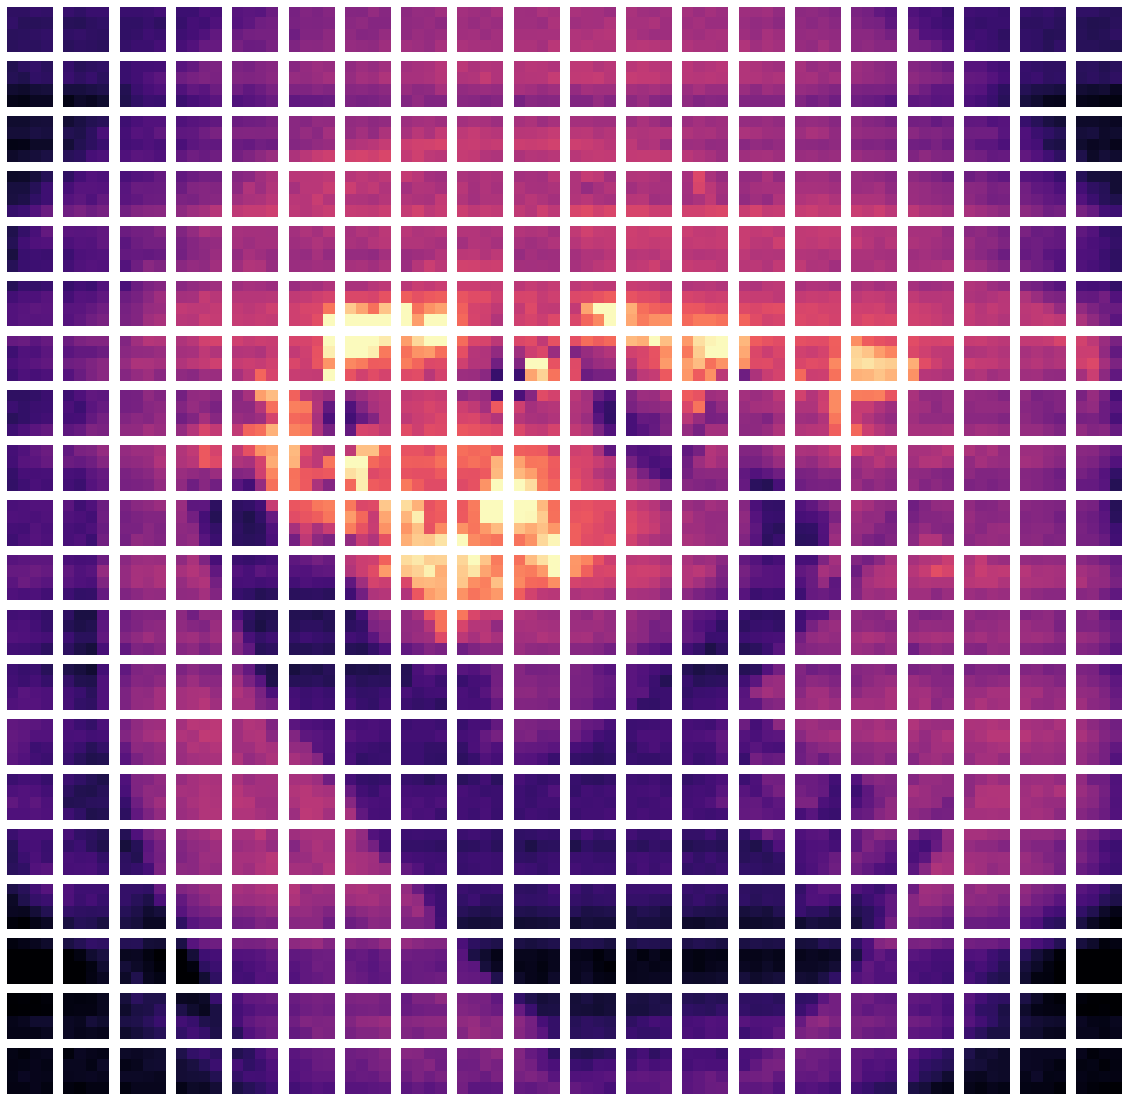

In [162]:
plot = tile_plotter(img_arr, 4, 4, 0, 255, int)
plot.show()

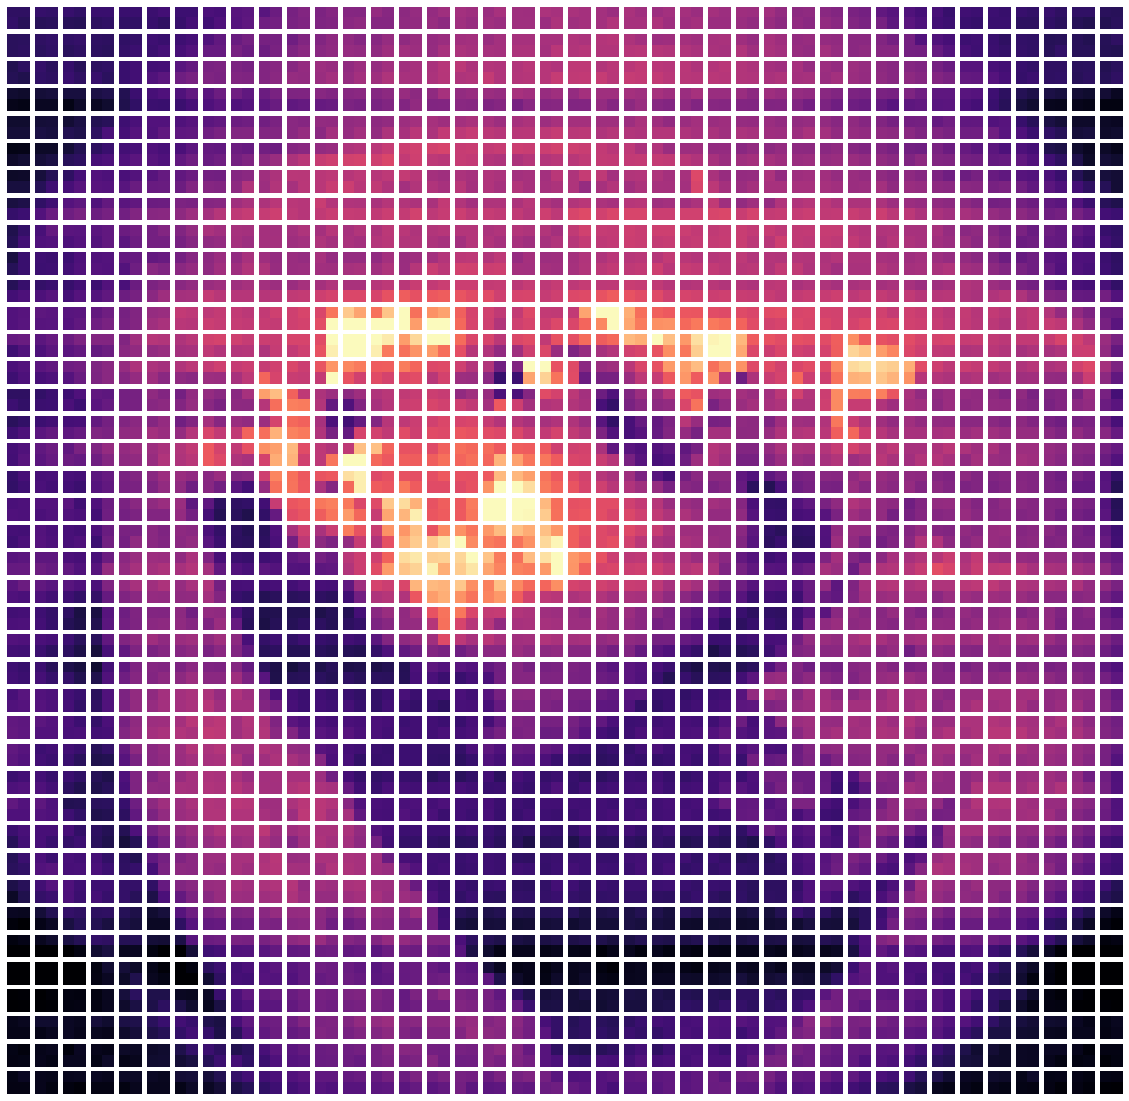

In [163]:
plot = tile_plotter(img_arr, 2, 2, 0, 255, int)
plot.show()

In [ ]:
# img1 = cv2.imread(files[0])
img2 = Image.open(img_arr).convert('L')
display(img2)


In [ ]:

# Convert to graycsale
# img_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_arr, (3,3), 0)

# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
# cv2.imshow('Sobel X', sobelx)
# cv2.waitKey(0)
# cv2.imshow('Sobel Y', sobely)
# cv2.waitKey(0)
# cv2.imshow('Sobel X Y using Sobel() function', sobelxy)
# cv2.waitKey(0)

In [ ]:

# sobelx1 = sobelx.resize([200,1200])
cv2.imshow('Sobel X', sobelx)
cv2.waitKey(0)
# img3 = Image.fromarray(sobelx, 'L')
# display(sobelx1)

In [ ]:
edges = cv2.Canny(image=raw_img, threshold1=100, threshold2=200)
display(edges)

In [ ]:
tile, w1, h1 = loop_tiler(2,2)
print(w1, h1)
print(len(tile))

In [ ]:
tli = tiler(2,2)
len(tli)

In [ ]:
'''
every layer is a magnification
find different aspects in layers
sliding window to detect
'''

In [ ]:
'''
[training layers]

<0. pre_filter (0-1 low cut filter)>
if val < 128:    val = 0

<1. turn off layer>
16x16  -  confidence
8 x 8  -  confidence
4 x 4  -  confidence
2 x 2  -  confidence
1 x 1  -  segment

<2. CNN layer>
16x16  -  confidence
8 x 8  -  confidence
4 x 4  -  confidence
2 x 2  -  confidence
1 x 1  -  segment


'''

In [ ]:
'''
[input]

1. previous data = Null: [-1], None: [0], else: [[x1_c, y1_c, d1, d2, a], [x2_c, y2_c, d1, d2, a], ... ]
2. now data : 80 x 80


'''

In [ ]:
'''
[output] - detect, localization

Null: [-1], None: [0], else: [[x1_c, y1_c, d1, d2, a], [x2_c, y2_c, d1, d2, a], ... ] = input_1


'''

In [ ]:
'''
[fundamentals]
1. ROI : track heat blob over (191, 2x2)
2. classify
3. bounding box : find most accurate bbox
'''

In [ ]:
'''
1. rnn base (detection from time base)
2.
3. 16x16 grid = binary classification
4. from active 1, 8x8 grid softmax, 0 < threshold < 1 = classification
5. from active 2, 4x4 grid softmax, 0 < threshold < 1 = classification
6. from active 3, 2x2 grid softmax, 0 < threshold < 1 = segmentation

7. average surrounding
8. segment finder
9.

'''

In [ ]:
'''
[rcnn]
remember
1. compare with previous. give more weight if detected in the past
2. make 0 if not moving

'''